## Company Profiling and Data Validation Task


This project cleanses, enriches, and validates company contact information using the Companies House API.
The final output includes matched and validated registered company names, number, addresses, postal codes, county and country.
Simple reporting and visualizations were added to summarize results.


In [1]:
#Import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import re

## 1. Data Loading and Initial Profiling

In [2]:
# Load the dataset
# Display the first few rows to understand the data
df = pd.read_csv('Company.csv')
df.head(5)

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,...,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,BULLDOG MINI SKIPS LTD,15330909,NaN,NaN,"YARD 1, ARNOCK BUNGALOW",SOUTHEND ARTERIAL ROAD,BRENTWOOD,NaN,UNITED KINGDOM,CM13 3TB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19/12/2024,NaN
1,BULLDOG LIMITED,09043007,NaN,NaN,FORESTERS COTTAGE,STONEY HEATH,BASINGSTOKE,HAMPSHIRE,NaN,RG26 5SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30/05/2025,16/05/2024
2,BULLDOG MUSHROOMS LTD,08465312,NaN,NaN,C58-59 NEW COVENT GARDEN MARKET,NINE ELMS LANE,NaN,NaN,NaN,SW8 5JJ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/04/2025,28/03/2024
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,01652098,NaN,NaN,5 RAVENSFIELD GARDENS,STONELEIGH,SURREY,NaN,NaN,KT19 0ST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/01/2025,18/12/2023
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,04667818,NaN,NaN,"FRP ADVISORY TRADING LIMITED, MOUNTBATTEN HOUSE",GROSVENOR SQUARE,SOUTHAMPTON,NaN,NaN,SO15 2RP,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08/02/2022,25/01/2021


In [3]:
# Basic information about the dataset
df.info()


# print dataset number of rows and column
print('This dataset contains', df.shape[0], 'rows and', df.shape[1], 'columns')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CompanyName                         307 non-null    object 
 1    CompanyNumber                      306 non-null    object 
 2   RegAddress.CareOf                   2 non-null      object 
 3   RegAddress.POBox                    5 non-null      object 
 4   RegAddress.AddressLine1             307 non-null    object 
 5    RegAddress.AddressLine2            191 non-null    object 
 6   RegAddress.PostTown                 254 non-null    object 
 7   RegAddress.County                   108 non-null    object 
 8   RegAddress.Country                  248 non-null    object 
 9   RegAddress.PostCode                 304 non-null    object 
 10  CompanyCategory                     306 non-null    object 
 11  CompanyStatus                       306 non-n

In [4]:
# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
CompanyName                             0
 CompanyNumber                          1
RegAddress.CareOf                     305
RegAddress.POBox                      302
RegAddress.AddressLine1                 0
 RegAddress.AddressLine2              116
RegAddress.PostTown                    53
RegAddress.County                     199
RegAddress.Country                     59
RegAddress.PostCode                     3
CompanyCategory                         1
CompanyStatus                           1
CountryOfOrigin                         2
DissolutionDate                       305
IncorporationDate                       2
Accounts.AccountRefDay                  6
Accounts.AccountRefMonth                5
Accounts.NextDueDate                    7
Accounts.LastMadeUpDate                85
Accounts.AccountCategory                1
Returns.NextDueDate                     8
Returns.LastMadeUpDate                206
Mortgages.NumMortCharges                2
Mortga

- Loaded `Company.csv` into a pandas DataFrame for initial exploration

- Reviewed basic information such as missing values, column data types, and shape. 

## 2. Data Cleaning

In [5]:
# Trim spaces from column names
df.columns = df.columns.str.strip()

# Strip leading/trailing spaces from object-type text fields
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    df[col] = df[col].str.strip()


In [6]:
# Handling Misaligned, Empty and Incorrect Entries

# Get the row as a Series
row = df.iloc[11]

# Shift the values 6 positions to the right
shifted_row = row.shift(periods=6)

# Replace the original row with the shifted row
df.iloc[11] = shifted_row

# Fill company number from URI Link
df.at[11, 'CompanyNumber'] = '01477370'

#
df.iloc[206, df.columns.get_indexer([  
    'RegAddress.AddressLine1',  
    'RegAddress.PostCode',
    'RegAddress.PostTown',
    'RegAddress.County'
])] = ['2340 Dulles Corner Blvd Suite 800', '20171', 'Herndon', 'Fairfax, Virginia']

#
df.iloc[270, df.columns.get_indexer([    
    'RegAddress.AddressLine1',
    'RegAddress.AddressLine2',
    'RegAddress.PostCode',
    'RegAddress.PostTown',
    'RegAddress.County',
    'RegAddress.Country'
])] = ['3500 S Dupont Highway', ' ', '19901', 'Dover', 'Kent, Delaware', 'United States']


#
df.iloc[4, df.columns.get_indexer([    
    'RegAddress.County',
    'RegAddress.Country'
])] = ['Hampshire', 'England']


#
df.iloc[119, df.columns.get_indexer([    
    'RegAddress.AddressLine2',
    'RegAddress.PostTown',
    'RegAddress.County',
    'RegAddress.Country'
])] = [' ', 'Croydon', 'London', 'England']


# List of target index positions
target_indexes = [147, 153, 225, 298]

# New values for county and country
new_county_values = ['Cardiff'] * 4
new_country_values = ['Wales'] * 4

# Update each row
for i, idx in enumerate(target_indexes):
    df.iloc[idx, df.columns.get_loc('RegAddress.County')] = new_county_values[i]
    df.iloc[idx, df.columns.get_loc('RegAddress.Country')] = new_country_values[i]

#display(df[df['CompanyNumber'] == 'FC014373'])
#display(df[df['CompanyNumber'] == 'FC039704'])
#display(df[df['RegAddress.PostCode'] == 'CF14 8LH'])
#display(df[df['CompanyNumber'] == '04667818'])

In [7]:
# Remove columns with too many missing values (benchmark: more than 90% missing)

benchmark = 0.9
missing_ratio = df.isnull().mean()
columns_to_drop = missing_ratio[missing_ratio > benchmark].index
df_cleaned = df.drop(columns=columns_to_drop)

print(f"Columns dropped due to high missing ratio: {list(columns_to_drop)}")

Columns dropped due to high missing ratio: ['RegAddress.CareOf', 'RegAddress.POBox', 'DissolutionDate', 'SICCode.SicText_3', 'SICCode.SicText_4', 'PreviousName_1.CONDATE', 'PreviousName_1.CompanyName', 'PreviousName_2.CONDATE', 'PreviousName_2.CompanyName', 'PreviousName_3.CONDATE', 'PreviousName_3.CompanyName', 'PreviousName_4.CONDATE', 'PreviousName_4.CompanyName', 'PreviousName_5.CONDATE', 'PreviousName_5.CompanyName', 'PreviousName_6.CONDATE', 'PreviousName_6.CompanyName', 'PreviousName_7.CONDATE', 'PreviousName_7.CompanyName', 'PreviousName_8.CONDATE', 'PreviousName_8.CompanyName', 'PreviousName_9.CONDATE', 'PreviousName_9.CompanyName', 'PreviousName_10.CONDATE', 'PreviousName_10.CompanyName']


In [8]:
# Convert appropriate fields to datetime (specifying DD/MM/YYYY format)
date_cols = ['IncorporationDate', 'Accounts.NextDueDate', 'Accounts.LastMadeUpDate', 
             'Returns.NextDueDate', 'Returns.LastMadeUpDate', 
             'ConfStmtNextDueDate', 'ConfStmtLastMadeUpDate']

for col in date_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = pd.to_datetime(df_cleaned[col], format='%d/%m/%Y', errors='coerce')


In [9]:
def clean_column_name(col):
    # Remove schema prefixes (e.g., 'RegAddress.')
    col = col.split('.')[-1]
    # Convert to snake_case
    col = re.sub(r'(?<=[a-z])(?=[A-Z0-9])|(?<=[A-Z])(?=[A-Z][a-z])', '_', col).lower()
    return col

# Apply function to dataframe
df_cleaned.columns = [clean_column_name(col) for col in df_cleaned.columns]

In [10]:
# Standardize both country and country_of_origin fields

# Defining a mapping for country name standardization
country_mapping = {
    'UK': 'United Kingdom',
    'ENGLAND': 'United Kingdom',
    'england': 'United Kingdom',
    'SCOTLAND': 'United Kingdom',
    'WALES': 'United Kingdom',
    'NORTHERN IRELAND': 'United Kingdom'
    
}


# Mapping to country if it exists
if 'country' in df_cleaned.columns:
    df_cleaned['country'] = df_cleaned['country'].replace(country_mapping)

# Mapping to country_of_origin if it exists
if 'country_of_origin' in df_cleaned.columns:
    df_cleaned['country_of_origin'] = df_cleaned['country_of_origin'].replace(country_mapping)


In [11]:
# Converting some columns to title case
def conditional_title(x):
    if isinstance(x, str):
        return x.title()
    return x

columns_to_title = [col for col in df_cleaned.columns if col not in ['post_code', 'company_name', 'uri']]

for col in columns_to_title:
    df_cleaned[col] = df_cleaned[col].apply(conditional_title)


# Define columns to convert to uppercase
uppercase_cols = ['post_code', 'company_name', 'company_number']

#Rename post_town column to city
#df_cleaned = df_cleaned.rename(columns={'post_town': 'city'})

# Converting specified columns to uppercase
df_cleaned[uppercase_cols] = df_cleaned[uppercase_cols].apply(lambda col: col.str.upper())


In [12]:
# Deduplication

# Check if 'company_number' has any missing values
missing_company_numbers = df_cleaned['company_number'].isnull().sum()
print(f"Missing Company Numbers: {missing_company_numbers}")

# Identify duplicate Company Numbers
duplicates = df_cleaned.duplicated(subset='company_number', keep=False)
print(f"\nNumber of Potential Duplicate Records based on company number: {duplicates.sum()}")


# Drop duplicates, keeping the first occurrence
df_cleaned = df_cleaned.drop_duplicates(subset='company_number', keep='first')

print(f"\nDataset shape after removing duplicates: {df_cleaned.shape}")


Missing Company Numbers: 0

Number of Potential Duplicate Records based on company number: 34

Dataset shape after removing duplicates: (290, 30)


- Columns with a high percentage of missing values (over 90%) were dropped

- Record at index 11 was found to have a misalignment (each value were shifted 6 positions right)

- Identified potential duplicate records based on `company_number`. Duplicates were reviewed, and only the first occurrence was retained.



In [13]:
df_cleaned.head()

,company_name,company_number,address_line_1,address_line_2,post_town,county,country,post_code,company_category,company_status,...,num_mort_outstanding,num_mort_part_satisfied,num_mort_satisfied,sic_text_1,sic_text_2,num_gen_partners,num_lim_partners,uri,conf_stmt_next_due_date,conf_stmt_last_made_up_date
0,BULLDOG MINI SKIPS LTD,15330909,"Yard 1, Arnock Bungalow",Southend Arterial Road,Brentwood,NaN,United Kingdom,CM13 3TB,Private Limited Company,Active,...,0.0,0.0,0,38110 - Collection Of Non-Hazardous Waste,43999 - Other Specialised Construction Activit...,0,0.0,http://business.data.gov.uk/id/company/15330909,2024-12-19,NaT
1,BULLDOG LIMITED,09043007,Foresters Cottage,Stoney Heath,Basingstoke,Hampshire,NaN,RG26 5SW,Private Limited Company,Active,...,0.0,0.0,0,68209 - Other Letting And Operating Of Own Or ...,NaN,0,0.0,http://business.data.gov.uk/id/company/09043007,2025-05-30,2024-05-16
2,BULLDOG MUSHROOMS LTD,08465312,C58-59 New Covent Garden Market,Nine Elms Lane,NaN,NaN,NaN,SW8 5JJ,Private Limited Company,Active,...,0.0,0.0,0,46310 - Wholesale Of Fruit And Vegetables,NaN,0,0.0,http://business.data.gov.uk/id/company/08465312,2025-04-11,2024-03-28
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,01652098,5 Ravensfield Gardens,Stoneleigh,Surrey,NaN,NaN,KT19 0ST,Private Limited Company,Active,...,0.0,0.0,0,90030 - Artistic Creation,93290 - Other Amusement And Recreation Activit...,0,0.0,http://business.data.gov.uk/id/company/01652098,2025-01-01,2023-12-18
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,04667818,"Frp Advisory Trading Limited, Mountbatten House",Grosvenor Square,Southampton,Hampshire,England,SO15 2RP,Private Limited Company,Liquidation,...,2.0,0.0,0,47710 - Retail Sale Of Clothing In Specialised...,NaN,0,0.0,http://business.data.gov.uk/id/company/04667818,2022-02-08,2021-01-25


## 3. API INTEGRATION

In [14]:
import os
import hashlib


# Set your API key here
API_KEY = 'enter_api_key_here'

# Define a cache directory
CACHE_DIR = 'api_cache'
os.makedirs(CACHE_DIR, exist_ok=True)

def get_cache_filename(company_number):
    hash_key = hashlib.md5(company_number.encode()).hexdigest()
    return os.path.join(CACHE_DIR, f"{hash_key}.json")

def query_companies_house_by_number(company_number):
    cache_file = get_cache_filename(company_number)
    
    # Return cached result if it exists
    if os.path.exists(cache_file):
        with open(cache_file, 'r') as file:
            return json.load(file)
    
    try:
        # API request
        response = requests.get(
            f'https://api.company-information.service.gov.uk/company/{company_number}',
            auth=(API_KEY, '')
        )
        
        if response.status_code == 404:
            print(f"Company Number {company_number} not found. (404)")
            result = {
                'api_match_found': False,
                'api_company_number': company_number,
                'api_company_status': '',
                'api_incorporation_date': '',
                'api_company_name': '',
                'api_address_line_1': '',
                'api_address_line_2': '',
                'api_postal_code': '',
                'api_locality': '',
                'api_country': ''
            }
        else:
            response.raise_for_status()
            data = response.json()
            address = data.get('registered_office_address', {})
            result = {
                'api_match_found': True,
                'api_company_number': company_number,
                'api_company_status': data.get('company_status', ''),
                'api_incorporation_date': data.get('date_of_creation', ''),
                'api_company_name': data.get('company_name', ''),
                'api_address_line_1': address.get('address_line_1', ''),
                'api_address_line_2': address.get('address_line_2', ''),
                'api_postal_code': address.get('postal_code', ''),
                'api_locality': address.get('locality', ''),
                'api_country': address.get('country', '')
            }
        
        # Save result to cache
        with open(cache_file, 'w') as file:
            json.dump(result, file)
        
        return result

    except Exception as e:
        print(f"Error querying {company_number}: {e}")
        return {
            'api_match_found': False,
            'api_company_number': company_number,
            'api_company_status': '',
            'api_incorporation_date': '',
            'api_company_name': '',
            'api_address_line_1': '',
            'api_address_line_2': '',
            'api_postal_code': '',
            'api_locality': '',
            'api_country': ''
        }


In [15]:
# Apply the updated function using company_number column
api_results = df_cleaned['company_number'].apply(query_companies_house_by_number)

# Convert to DataFrame
api_results_df = pd.json_normalize(api_results)

In [16]:
# Queried postcodes.io API w.r.t original data postcode to extract correct UK city, county and country name
def enrich_with_postcode_info(postcode):
    try:
        postcode = str(postcode).strip().replace(" ", "")
        response = requests.get(f"https://api.postcodes.io/postcodes/{postcode}")
        
        if response.status_code == 200:
            data = response.json().get('result', {})
            return {
                'api_2_postcode_valid': True,
                'api_2_city': data.get('admin_district', ''),
                'api_2_county': data.get('admin_county') or data.get('region', ''),
                'api_2_country': data.get('country', '')
            }
        else:
            return {
                'api_2_postcode_valid': False,
                'api_2_city': '',
                'api_2_county': '',
                'api_2_country': ''
            }
    except:
        return {
            'api_2_postcode_valid': False,
            'api_2_city': '',
            'api_2_county': '',
            'api_2_country': ''
        }


In [17]:
#Applied queried UK contact information from postcodes.io API
postcode_info = api_results_df['api_postal_code'].apply(enrich_with_postcode_info)
postcode_df = pd.DataFrame(postcode_info.tolist())

#Merged queried UK contact information from postcodes.io API
api_results_df = pd.concat([api_results_df.reset_index(drop=True), postcode_df.reset_index(drop=True)], axis=1)


In [18]:
# Merges original dataset with the API-enriched data row by row
df_final = pd.concat([df_cleaned.reset_index(drop=True), api_results_df.reset_index(drop=True)], axis=1)

# Replace blank strings, whitespace-only, and placeholders with real NaN
df_final = df_final.replace(r'^\s*$', pd.NA, regex=True)  # empty or whitespace


# Display result
df_final.head(5)

,company_name,company_number,address_line_1,address_line_2,post_town,county,country,post_code,company_category,company_status,...,api_company_name,api_address_line_1,api_address_line_2,api_postal_code,api_locality,api_country,api_2_postcode_valid,api_2_city,api_2_county,api_2_country
0,BULLDOG MINI SKIPS LTD,15330909,"Yard 1, Arnock Bungalow",Southend Arterial Road,Brentwood,NaN,United Kingdom,CM13 3TB,Private Limited Company,Active,...,BULLDOG MINI SKIPS LTD,"Yard 1, Arnock Bungalow",Southend Arterial Road,CM13 3TB,Brentwood,United Kingdom,True,Brentwood,Essex,England
1,BULLDOG LIMITED,09043007,Foresters Cottage,Stoney Heath,Basingstoke,Hampshire,NaN,RG26 5SW,Private Limited Company,Active,...,BULLDOG MORTLAKE LIMITED,Foresters Cottage,Stoney Heath,RG26 5SW,Basingstoke,<NA>,True,Basingstoke and Deane,Hampshire,England
2,BULLDOG MUSHROOMS LTD,08465312,C58-59 New Covent Garden Market,Nine Elms Lane,NaN,NaN,NaN,SW8 5JJ,Private Limited Company,Active,...,BULLDOG MUSHROOMS LTD,C58-59 New Covent Garden Market,Nine Elms Lane,SW8 5JJ,London,<NA>,True,Wandsworth,London,England
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,01652098,5 Ravensfield Gardens,Stoneleigh,Surrey,NaN,NaN,KT19 0ST,Private Limited Company,Active,...,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,5 Ravensfield Gardens,Stoneleigh,KT19 0ST,Surrey,<NA>,True,Epsom and Ewell,Surrey,England
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,04667818,"Frp Advisory Trading Limited, Mountbatten House",Grosvenor Square,Southampton,Hampshire,England,SO15 2RP,Private Limited Company,Liquidation,...,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,"Frp Advisory Trading Limited, Mountbatten House",Grosvenor Square,SO15 2RP,Southampton,<NA>,False,<NA>,<NA>,<NA>


- Utilized direct Company Number lookups via the Companies House API. This provides faster, more accurate enrichment of contact and company information.

- Merges selected fields from the original company records and matched Companies House API results. 

- Key fields include both the original and validated company names, numbers, and detailed registered address.


## 4. Contact Information Matching and Validation

In [19]:
from difflib import SequenceMatcher

# Similarity function
def field_similarity(a, b):
    if pd.isnull(a) or pd.isnull(b):
        return 0
    return SequenceMatcher(None, str(a).lower(), str(b).lower()).ratio()

# Fields to validate
fields = {
    'company_name': 'api_company_name',
    'company_number': 'api_company_number',
    'address_line_1': 'api_address_line_1',
    'address_line_2': 'api_address_line_2',
    'post_town': 'api_2_city',
    'post_code': 'api_postal_code',
    'county':'api_2_county',
    'country': 'api_2_country'
    
}


# Create match summary
match_results = {}
for original, api in fields.items():
    if 'name' in original or 'address' in original:
        match = df_final.apply(lambda row: field_similarity(row[original], row[api]) >= 0.8, axis=1)
    else:
        match = df_final.apply(lambda row: str(row[original]).strip().lower() == str(row[api]).strip().lower(), axis=1)
    match_results[original] = round(match.mean() * 100, 2)




Validation focused on:
- Company name (fuzzy match)
- Company number (exact match)
- Address line 1 & 2 (fuzzy match)
- City, Country and postal code (exact match)

Below is a summary of the percentage of records that successfully matched between the original cleaned and API data.


In [20]:
# Show match results
match_df = pd.DataFrame.from_dict(match_results, orient='index', columns=['Match Rate (%)'])
display(match_df)

,Match Rate (%)
company_name,94.48
company_number,100.00
address_line_1,82.76
address_line_2,53.45
post_town,22.76
post_code,84.83
county,19.31
country,0.34


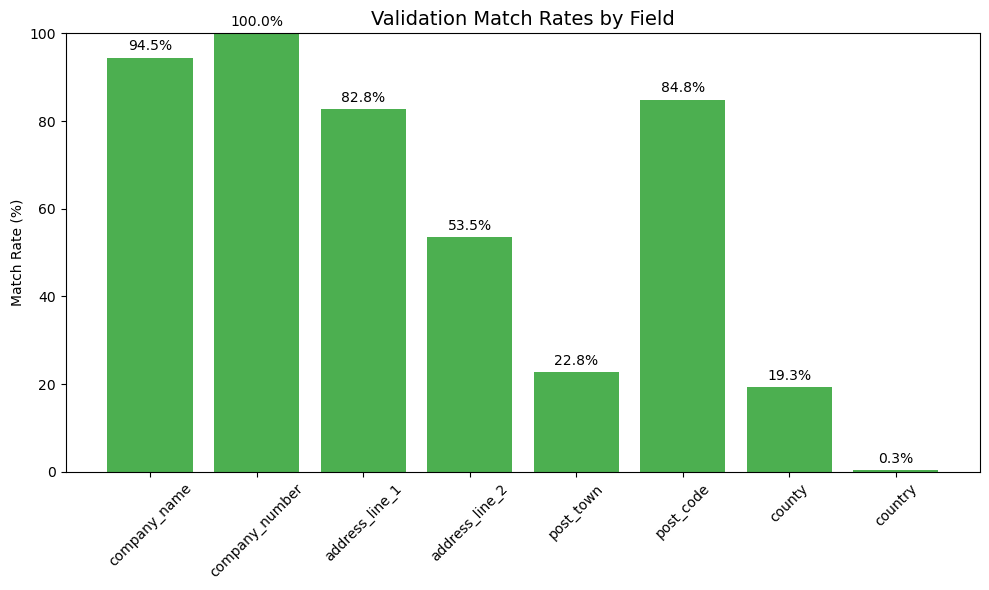

In [21]:
# Bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(match_df.index, match_df['Match Rate (%)'], color='#4CAF50')

# Add title and labels
plt.title('Validation Match Rates by Field', fontsize=14)
plt.ylabel('Match Rate (%)')
plt.xticks(rotation=45)
plt.ylim(0, 100)

# Add data labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom')

# Display chart
plt.tight_layout()
plt.show()




The above bar chart shows the percentage of records where each field (company name, number, address, city, country, postal code) matched successfully between the original dataset and the Companies House API data.


In [22]:
display(df_final[df_final['company_number'] == '07245964'])

,company_name,company_number,address_line_1,address_line_2,post_town,county,country,post_code,company_category,company_status,...,api_company_name,api_address_line_1,api_address_line_2,api_postal_code,api_locality,api_country,api_2_postcode_valid,api_2_city,api_2_county,api_2_country
77,BULLE & BAER LTD,07245964,The 606 Centre,5A Cuthbert Street,NaN,NaN,NaN,W2 1XT,Private Limited Company,Active,...,BULLE & BAER LTD,The 606 Centre,5a Cuthbert Street,W2 1XT,London,<NA>,False,<NA>,<NA>,<NA>


## 5. Data Enrichment

In [23]:
# Create a new DataFrame for final enriched records
final_enriched = pd.DataFrame()

# Fill each final column: use API if available, else original
for original_record, api_record in fields.items():
    final_enriched[original_record] = df_final[api_record].combine_first(df_final[original_record])
                                       

# Exclude company_number = '05883574' as the company number was not found
final_enriched = final_enriched[final_enriched['company_number'] != '05883574']


final_enriched.iloc[77, final_enriched.columns.get_indexer([
    'post_code',
    'post_town',
    'county',
    'country'
])] = ['W2 1ST', 'London', 'Greater London', 'England']


final_enriched.iloc[104, final_enriched.columns.get_indexer([
    'address_line_1',
    'post_code',
    'country'
])] = ['Unit 10 The Oaks Industrial Estate', 'LE11 5XN', 'England']


# Fill NaN values in 'county' with values from 'city'
final_enriched['county'] = final_enriched['county'].fillna(final_enriched['post_town'])


In [24]:
# Sort alphabetically by 'company_name'
final_enriched = final_enriched.sort_values(by='company_name').reset_index(drop=True)

# Preview
print("\nFinal Enriched Dataset:")
final_enriched.head(5)


Final Enriched Dataset:


,company_name,company_number,address_line_1,address_line_2,post_town,post_code,county,country
0,360 LAB LTD,14869093,Flat 5 61a Kirgate House,NaN,Bradford,BD1 1PZ,Yorkshire and The Humber,England
1,AIRLINE RESERVATION LIMITED,14498022,85 Great Portland Street,NaN,Westminster,W1W 7LT,London,England
2,AIRLINE ROTABLES (UK HOLDINGS) LIMITED,02637160,2 Minton Place,Victoria Road,Cherwell,OX26 6QB,Oxfordshire,England
3,AIRLINE SERVICES AND COMPONENTS GROUP LIMITED,07652548,Squire Patton Boggs (Uk) Llp (Ref: Csu) Rutlan...,148 Edmund Street,Birmingham,B3 2JR,West Midlands,England
4,AIRLINE SERVICES COMPONENTS LIMITED,01503647,Squire Patton Boggs (Uk) Llp (Ref: Csu) Rutlan...,148 Edmund Street,Birmingham,B3 2JR,West Midlands,England


Each contact information field was enriched by prioritizing Companies House API data.  If no API data was available for a field, the original Company.csv value was used as fallback.

- A specific record with `company_number = 05883574` was removed as its not a registered company number.
- The final dataset was sorted alphabetically by company name.

In [25]:
# Check for missing values
n = 10
m = 8

print("\nMissing Values per Column of Original Data:")
missing_counts = df.isnull().sum()
print(missing_counts.iloc[:n])


print("\nMissing Values per Column of Cleaned Data:")
cleaned_missing_counts = df_cleaned.isnull().sum()
print(cleaned_missing_counts.iloc[:m])


print("\nMissing Values per Column of Enriched Data:")
print(final_enriched.isnull().sum())


Missing Values per Column of Original Data:
CompanyName                  1
CompanyNumber                0
RegAddress.CareOf          305
RegAddress.POBox           303
RegAddress.AddressLine1      1
RegAddress.AddressLine2    117
RegAddress.PostTown         52
RegAddress.County          193
RegAddress.Country          53
RegAddress.PostCode          1
dtype: int64

Missing Values per Column of Cleaned Data:
company_name        0
company_number      0
address_line_1      0
address_line_2    106
post_town          48
county            181
country            49
post_code           1
dtype: int64

Missing Values per Column of Enriched Data:
company_name        0
company_number      0
address_line_1      0
address_line_2    100
post_town           0
post_code           0
county              0
country             0
dtype: int64


In [26]:
# print dataset number of rows and column
print('This dataset contains', final_enriched.shape[0], 'rows and', final_enriched.shape[1], 'columns')

This dataset contains 289 rows and 8 columns


## 6. Export Enriched Dataset

In [27]:
# Save final matched contact information to CSV
final_enriched.to_csv('final_enriched.csv', index=False)

# 7. Conclusion

In this project, a complete data enrichment and validation pipeline was developed for UK company records.  The solution performed data cleaning, API-based enrichment using Companies House, and field-by-field validation for company name, number, address, city and postcode.  

All enrichment prioritized API data with fallbacks to original values, ensuring accuracy and completeness.  The final enriched dataset is sorted, cleaned, and exported — ready for business use or downstream analytics.

This project demonstrates a scalable, API-driven data engineering workflow.
